## Emotion Detection and Classification based on Facial Expression Input -
The objective is to design an emotion recognition system from facial features input in order to determine, say, the mood, of a person. This work is a subpart of a project called Innoguide in which my team in Ibot Club at IIT Madras attempts to build a tour guide humanoid robot. The aspect of emotion detection using facial recognition will prove to be useful in interface, ie, when the robot is interacting with the user. Ideally, the robot analyses the emotion of the users from their facial expressions (as well as speech, which will also be attempted) and responds appropriately. The information retrieved from this analysis could perhaps, say, be given as an additional input to the LLM inside the robot which then speaks back to the user appropriately. This could also be used to determine what kind of facial expression the robot should have on its "face screen" while interacting. Overall, it tries to improve the interaction experience between the robot and the user.

We fine-tune a pre-trained VGG model for emotion recognition from a face expression image input. For this, we use the publicly available FER-2013 dataset which has a huge collection of greyscale facial expression images with a set of emotion labels to be classified to. We stick to these set of emotions for now given how complex it can get if we go further.Instead of using the final best output, we could use the probability vector as output which gives a vector of probabilities for all possible emotions from the set. This could be better used in other tasks appropriately.
We use tensorflow to write code and get the model due to its ease, well-documented website and wide support for deploying on edge devices.


In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import CategoricalAccuracy, F1Score, AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

### Data loading

In [2]:
# Get data
!git clone https://github.com/aadarshram/InnoGuide_GPT.git

fatal: destination path 'InnoGuide_GPT' already exists and is not an empty directory.


In [3]:
import os
os.chdir('/content/InnoGuide_GPT/emotion_detection')

In [4]:
data_dir = '.'
train_ds = image_dataset_from_directory(
    directory = f'{data_dir}/train',
    image_size = (256, 256),
    batch_size = 32,
    label_mode = 'int'
)
test_ds = image_dataset_from_directory(
    directory = f'{data_dir}/test',
    image_size = (256, 256),
    batch_size = 32,
    label_mode = 'int'
)


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


## Understanding the data

In [5]:
# Find classes
class_names = train_ds.class_names
num_classes = len(class_names)
print('Classes: ', class_names, 'totally ', num_classes)

Classes:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] totally  7


In [6]:
# Check if all classes are balanced
for class_name in class_names:
  class_path = os.path.join(data_dir, 'train', class_name)
  num_images = len(os.listdir(class_path))
  print(f'Class {class_name} has {num_images} images')

Class angry has 3995 images
Class disgust has 436 images
Class fear has 4097 images
Class happy has 7215 images
Class neutral has 4965 images
Class sad has 4830 images
Class surprise has 3171 images


There is an imbalance. Can try class weighting to deal with this.

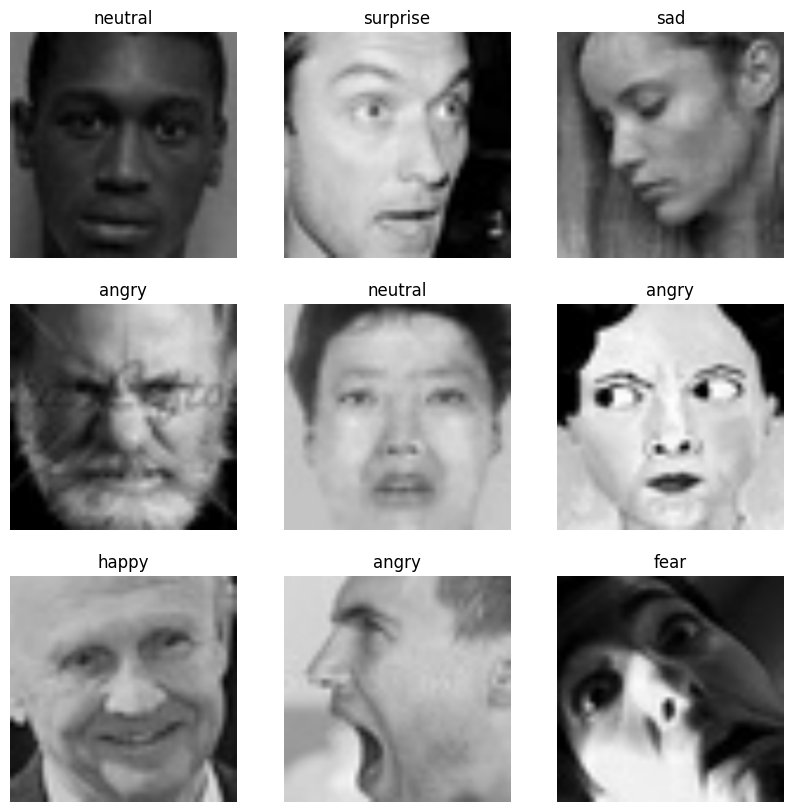

In [7]:
# Visualize some of the images
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(images[i].numpy().astype('uint8'))
    ax.set_title(class_names[labels[i]])
    ax.axis('off')

## Data Preprocessing

In [8]:
# Class weighting
labels = []
for _, label_batch in train_ds:
  labels.extend(label_batch.numpy())
classes = np.unique(labels)
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y = labels
)
class_weights = dict(zip(classes, class_weights))

In [9]:
# Configure dataset for optimal performance (takes lot of RAM)
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().shuffle(50).prefetch(buffer_size = AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [10]:
# Data augmentation to ensure it captures variability
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

## Model

In [11]:
# Get base model
base_model = tf.keras.applications.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (256, 256, 3)
)
# Make only final two layers trainable
base_model.trainable = False
for layer in base_model.layers[-1:]:
  layer.trainable = True
# Make final model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape = (256, 256, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation = 'softmax')
])

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 3,591 (14.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
lr = 0.001 # learning rate
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr), # Use Adam optimizer
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [14]:
# Enable checkpointing and early stopping
checkpoint_path = 'ckpt.keras'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose = 1, restore_best_weights = True)


### Train

In [15]:
def train(epochs):
  history = model.fit(
      train_ds,
      validation_data = test_ds,
      epochs = epochs,
      callbacks = [checkpoint, early_stopping],
      class_weight = class_weights
  )
  return history

In [16]:
def plot_results(history):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Test'])
  return None

In [ ]:
history = train(20)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.2300 - loss: 2.6625
Epoch 1: val_accuracy improved from -inf to 0.36723, saving model to ckpt.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 234s 247ms/step - accuracy: 0.2301 - loss: 2.6620 - val_accuracy: 0.3672 - val_loss: 1.8866
Epoch 2/20
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.3477 - loss: 1.8055
Epoch 2: val_accuracy improved from 0.36723 to 0.39231, saving model to ckpt.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 292s 291ms/step - accuracy: 0.3477 - loss: 1.8054 - val_accuracy: 0.3923 - val_loss: 1.7078
Epoch 3/20
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.3793 - loss: 1.6981
Epoch 3: val_accuracy improved from 0.39231 to 0.43856, saving model to ckpt.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 261s 291ms/step - accuracy: 0.3793 - loss: 1.6981 - val_accuracy: 0.4386 - val_loss: 1.5707
Epoch 4/20
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.3895 - loss: 1.6766
Epoch 4: val_accuracy did not improve f

### Evaluate

In [ ]:
# Get best weights
model.load_weights(checkpoint_path)

In [ ]:
# Check best accuracy, loss and F1Score

val_acc_list = history.history['val_accuracy']
best = val_acc_list.index(max(val_acc_list))

train_acc = history.history['accuracy'][best]
val_acc = history.history['val_accuracy'][best]

train_loss = history.history['loss'][best]
val_loss = history.history['val_loss'][best]

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print('Train Loss:', train_loss)
print('Validation Loss:', val_loss)

In [ ]:
# get val_pred and val_true

val_pred_labels = model.predict(val_ds)
threshold = 0.7
val_pred_labels = (val_pred_labels > threshold).astype(int)
val_labels = []
for images, labels in val_df:
  for label in labels:
    val_labels.append(label)
val_labels = np.array(val_labels)

# Calculate macro F1 score (micro will be same as accuracy since it is multi-class and not multi-label classification)
val_f1 = f1_score(val_labels, val_pred_labels, average='macro')
print("Validation F1 Score (macro):", val_f1)
print('-' * 15)
# Additional:

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, val_pred_labels)
print("Confusion Matrix:\n", conf_matrix)
print('-' * 15)
# Classification report
class_report = classification_report(val_labels, val_pred_labels)
print("Classification Report:\n", class_report)
print('-' * 15)

### Results

??